In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
def amean(da,cf=1/365):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf*(m*da).groupby('time.year').sum().compute()
    return xa

In [3]:
def fix_time(ds):
    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    return ds

In [4]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [5]:
d='/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/'
f='PPEn11_transient_LHC{}.clm2.{}.{}-02-01-00000.nc'


In [6]:
def pp(ds):
    dvs=['GPP','TOTVEGC']
    return fix_time(ds[dvs])

In [7]:
def pp0(ds):
    dvs=['TBOT','QBOT','WIND','SNOW','RAIN','PBOT','FSDS','FLDS']
    return fix_time(ds[dvs])

In [8]:
#only need one h0 member, because they should all be the same
h0files=[d+f.format('0000','h0','2005') for yy in range(2005,2015,5)]
ds0=fix_time(xr.open_mfdataset(h0files,combine='nested',concat_dim='time',preprocess=pp0)) 
tmp=xr.open_dataset(h0files[0])
for v in tmp:
    if 'grid1d' in v:
        ds0[v]=tmp[v]

In [15]:
#read in some h1 data
yy='2005'
h1files=[d+f.format(str(i).zfill(4),'h1',yy) for i in range(1,501)]
ds1=xr.open_mfdataset(h1files,combine='nested',concat_dim='ens',
                      parallel=True,preprocess=pp)
tmp=xr.open_dataset(h1files[0])
for v in tmp:
    if ('pfts1d' in v)|('grid1d' in v):
        ds1[v]=tmp[v]

In [63]:
#create the gc_to_pft indexer
latlon_gc=ds0.grid1d_jxy*1000+ds0.grid1d_ixy
gkey={g:i for i,g in enumerate(latlon_gc.values)}
latlon_pft=ds1.pfts1d_jxy*1000+ds1.pfts1d_ixy
gc_to_pft=xr.DataArray([gkey[p] for p in latlon_pft.values],dims='pft',name='gridcell')

In [64]:
dvs=['TBOT','QBOT','WIND','SNOW','RAIN','PBOT','FSDS','FLDS']
for v in dvs:
    ds1[v]=ds0[v].isel(gridcell=gc_to_pft).compute()

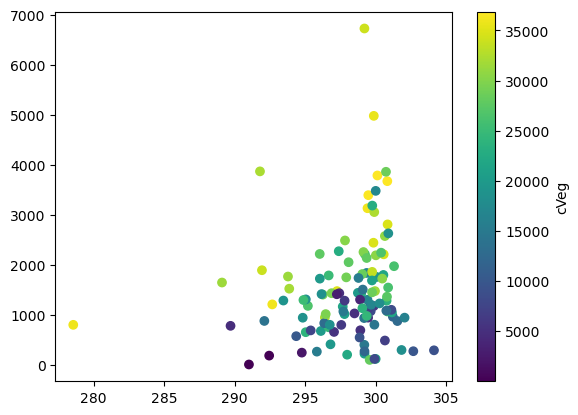

In [65]:
ixpft=ds1.pfts1d_itype_veg==4
cf=24*60*60*365 #mm/yr
plt.scatter(ds1.TBOT.isel(pft=ixpft).mean(dim='time'),
            cf*(ds1.RAIN+ds1.SNOW).isel(pft=ixpft).mean(dim='time'),
            c=ds1.TOTVEGC.isel(pft=ixpft,ens=0).mean(dim='time'))
plt.colorbar(label='cVeg');

### cveg weighting

In [ ]:
la=xr.open_dataset('/glade/campaign/cgd/tss/projects/PPE/helpers/nonrepresentative_pftarea.nc').lapft

In [134]:
pftsubset=range(1,17)
def pp(ds):
    pvs=['medlynslope','kmax']
    return ds[pvs].isel(pft=pftsubset)
d='/glade/campaign/asp/djk2120/PPEn11/paramfiles/'
f='LHC{}.nc'
pfiles=[d+f.format(str(i).zfill(4)) for i in range(1,501)]
params=xr.open_mfdataset(pfiles,combine='nested',concat_dim='ens',
                         preprocess=pp,parallel=True)
params['veg']=xr.DataArray(range(16),dims='pft')
params=params.swap_dims({'pft':'veg'})
pftnames=[str(p)[2:-1].strip() for p in xr.open_dataset(pfiles[0]).pftname[range(1,17)].values]

In [66]:
#pft regridder
isveg=ds1.pfts1d_itype_veg>0
ix=xr.DataArray(np.zeros([400,16]),dims=['gridcell','veg']).stack({'gp':['gridcell','veg']})
ix[:]=ds1.pft[isveg].values
regridder=ix.unstack().astype(int)

In [ ]:
#calculate and regrid cveg
cveg=amean(ds1.TOTVEGC).isel(pft=regridder).compute()

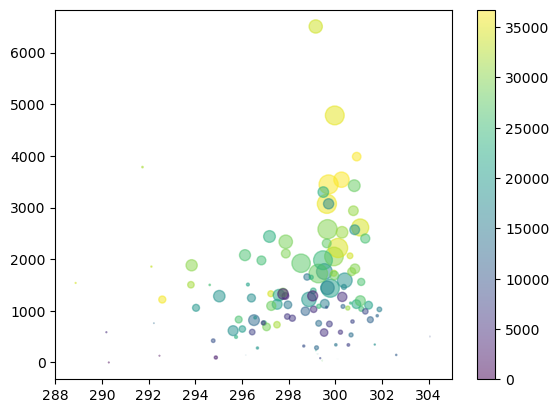

In [138]:
#sanity check plot
t=amean(ds1.TBOT).isel(pft=regridder).compute()
p=amean(ds1.RAIN+ds1.SNOW).isel(pft=regridder).compute()

plt.scatter(t.isel(year=0,veg=3),
            cf*p.isel(year=0,veg=3),
            c=cveg.isel(ens=0,year=0,veg=3),
            s=la.sel(year=2005,pft=regridder).isel(veg=3)/300,
            alpha=0.5);
plt.colorbar()
plt.xlim([288,305]);

In [164]:
%%time
#compute weighting vector
w=(cveg*la.isel(pft=regridder)).compute()
wsum=w.sum().compute()

CPU times: user 773 ms, sys: 931 ms, total: 1.7 s
Wall time: 1.97 s


In [163]:
%%time
#weighted average medlynslope
xavg=params.medlynslope.weighted(w).mean(dim='veg').compute() 

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 245.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 7.95 s, sys: 737 ms, total: 8.69 s
Wall time: 35.5 s


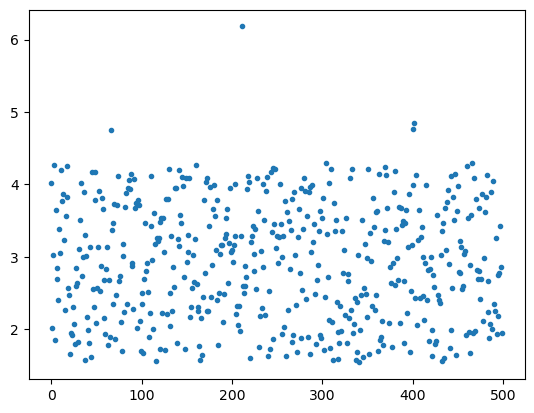

In [166]:
plt.plot(xavg.isel(year=0,gridcell=300),'.');

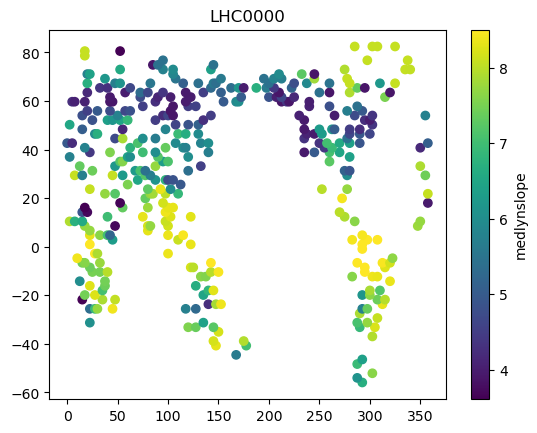

In [169]:
plt.scatter(ds1.grid1d_lon,ds1.grid1d_lat,
            c=xavg.isel(year=0,ens=0));
plt.title('LHC0000')
plt.colorbar(label='medlynslope');